In [1]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cunusht
import sys
from time import process_time

import cupy as cp
from delensalot.sims.sims_lib import Xunl, Xsky
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

runinfos = [
    # ("CPU", "lenspyx", 'ducc'),
    ("CPU", "duccnufft", 'ducc'),
    ("GPU", "cufinufft", 'shtns')
    ]

lmaxs = [1023]
# epsilons = np.array([1e-4, 1e-5, 1e-6, 1e-7])
epsilons = [1e-02, 1e-06, 1e-10]
# epsilons = np.arange(1e-10,1e-6+1e-7,5e-8) # double precision
nthreads = 20
phi_lmaxs = [lmax for lmax in lmaxs]
defres = {}
Tsky = None
Tsky2 = None
truth = None
pixs = None
errdata = []

def err(nom, denom):
    return np.sqrt(np.sum(np.power(nom,2)/np.sum(denom)))

def nalm(lmax, mmax=None):
    mmax = lmax if mmax is None else mmax
    return int(((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax))
for epsilon in epsilons:
    for lmax, phi_lmax in zip(lmaxs, phi_lmaxs):
        geominfo = ('gl',{'lmax':lmax})
        lenjob_geominfo = ('gl',{'lmax':phi_lmax})
        lldlm = np.arange(0,phi_lmax+1)
        synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
        synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=lenjob_geominfo, epsilon=1e-10)
        philm = synunl.get_sim_phi(0, space='alm')
        toydlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))
        toyunllm = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
        Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
        Tsky2 = synsky.unl2len(toyunllm, philm, spin=0)
        # nalm_unl = hp.Alm.getsize(lmax, mmax=lmax)
        # toyunllm = np.random.rand(nalm_unl)*1e-6 + 1j*np.random.rand(nalm_unl)*1e-6
        # toydlm = np.random.rand(nalm_unl)*1e-6 + 1j*np.random.rand(nalm_unl)*1e-6

        for runinfo in runinfos:
            backend = runinfo[0]
            defres.update({backend: {}}) if backend not in defres.keys() else None
            solver = runinfo[1]
            defres[backend].update({solver : None}) if solver not in defres[backend].keys() else None
            
            t = cunusht.get_transformer(backend, solver)
            if backend == 'CPU':
                if solver == 'lenspyx':
                    kwargs = {
                        'geominfo_deflection': lenjob_geominfo,
                        'dglm': toydlm,
                        'mmax_dlm': lmax,
                        'nthreads': nthreads,
                        'verbose': 1,
                        'epsilon': epsilon,
                        'single_prec': False,
                    }   
                    t = t(**kwargs)
                    defres[backend][solver] = t.gclm2lenmap(
                            toyunllm.copy(), dlm=toydlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, execmode='debug', ptg=None)
                else:
                    kwargs = {
                        'geominfo_deflection': lenjob_geominfo,
                        'nuFFTtype': None,
                    }
                    t = t(**kwargs)
                    defres[backend][solver] = t.gclm2lenmap(
                            gclm=toyunllm.copy(),
                            dlm=toydlm, lmax=lmax, mmax=lmax, spin=0,
                            nthreads=nthreads, epsilon=epsilon, execmode='debug', ptg=None)
                ptg = t.deflectionlib.dlm2pointing(toydlm, mmax_dlm=lmax, single_prec=False, nthreads=nthreads)
                
                orig_list = np.arange(0,t.deflectionlib.geom.npix()).tolist()
                pixs = np.array(random.sample(orig_list, 10000))
                # pixs = np.arange(t.deflectionlib.geom.ofs[lmax//2], t.deflectionlib.geom.ofs[lmax//2]+30000).astype(int)
                truth = t.gclm2lenpixs(toyunllm.copy(), mmax=None, spin=0, pixs=pixs, ptg=ptg)                
            elif backend == 'GPU':
                kwargs = {
                    'geominfo_deflection': lenjob_geominfo,
                    'epsilon': epsilon,
                    'nuFFTtype': 2,
                }   
                t = t(**kwargs)
                lenmap = cp.empty(t.deflectionlib.constructor.spat_shape, dtype=cp.complex128).flatten()
                ll = np.arange(0,lmax+1,1)
                dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
                dlm_scaled = cp.array(np.atleast_2d(dlm_scaled), dtype=np.complex128) if kwargs['epsilon']<=1e-6 else cp.array(np.atleast_2d(dlm_scaled).astype(np.complex64))
                defres[backend][solver] = t.gclm2lenmap(cp.array(toyunllm.copy()), dlm_scaled=dlm_scaled, lmax=lmax, mmax=lmax, lenmap=lenmap, execmode='debug')#, ptg=cp.array(ptg))
    keyCPU = 'synthesisgeneral'
    keyGPU = 'nuFFT2d2'
    resCPU = defres['CPU'][runinfos[0][1]][keyCPU].real
    resGPU = defres['GPU']['cufinufft'][keyGPU].real
    solverCPU, solverGPU = runinfos[0][1], 'cufinufft'
    errdata.append([err(truth-resGPU[pixs], truth), err(truth-resCPU.flatten()[pixs], truth)])
    
"recompile for H-100"

mpisupport: False, pmisupport: False
disabling mpi
could not load wigners.so fortran shared object
try f2py -c -m wigners wigners.f90 from the command line in wigners directory ?
Using lenspyx alm2map
INFO:: 05-31 18:25:14:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-31 18:25:14:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 05-31 18:25:14:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-31 18:25:14:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
deflection std is 2.58e+00 amin
Running in {} execution mode
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,), (2097152,)], types

/tmp/ipykernel_1804609/2826399980.py:102: RuntimeWarning: divide by zero encountered in divide
  dlm_scaled = hp.almxfl(toydlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


INFO:: 05-31 18:25:22:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-31 18:25:22:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
deflection std is 2.58e+00 amin
Running in {} execution mode
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,), (2097152,)], types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
- - - - - - - - - - - - - - - Timing synthesis: 0.022 seconds- - - - - - - - - - - - - - - 

U2nu:
  nthreads=12, grid=(2048x2062), oversampled grid=(2772x2800), supp=10, eps=1e-06
  npoints=2097152
  memory overhead: 0.0078125GB (index) + 0.115657GB (oversampled grid)

Total wall clock time for u2nu: 0.04828s
|
+- u2nu proper          : 85.58% (0.

setup_spreader warning: at upsampfac=1.25, tol=1e-10 would need kernel width ns=17; clipping to max 16.


'recompile for H-100'

## Only for lenpsyx

In [6]:
defres['CPU']['lenspyx'].keys(), defres['GPU']['cufinufft'].keys()

(dict_keys(['dlm2pointing', 'synthesisgeneral']),
 dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT2d2']))

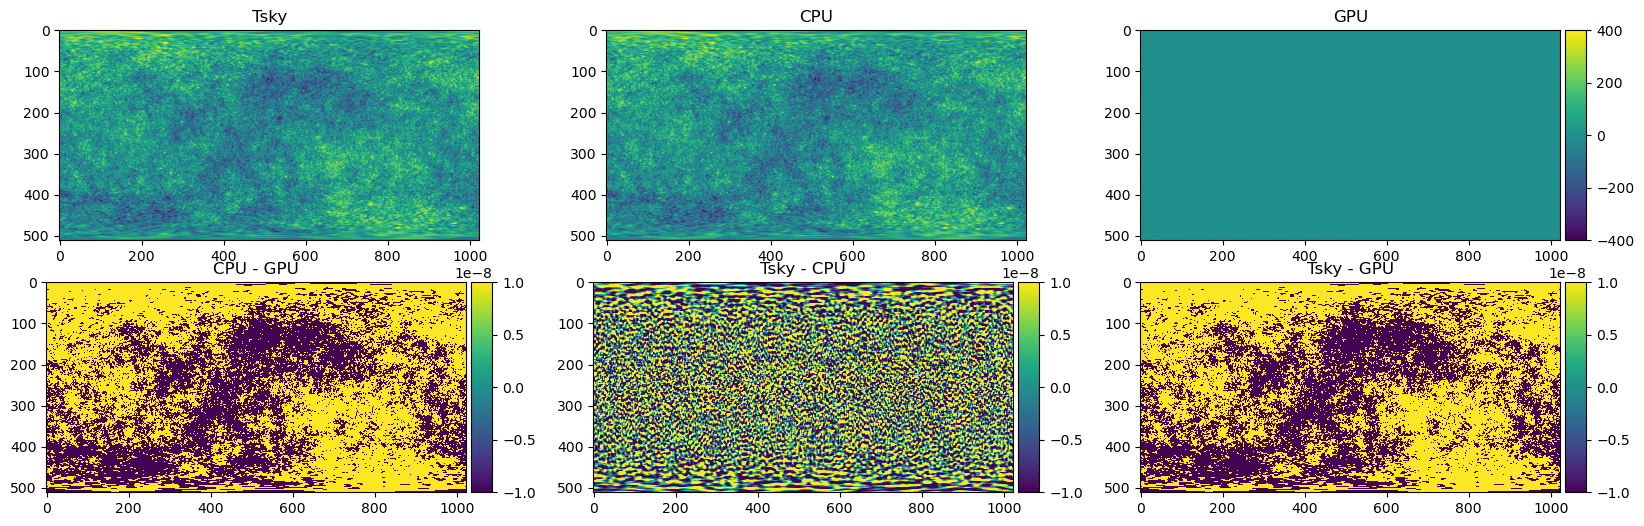

In [13]:
keyCPU = 'synthesisgeneral'
keyGPU = 'nuFFT2d2'
Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU']['lenspyx'][keyCPU].real
resGPU = defres['GPU']['cufinufft'][keyGPU].real

fig, ax = plt.subplots(2,3, figsize=(20,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

vmin, vmax= -epsilon*1e0, epsilon*1e0 # -1e-12, 1e-12

im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

### check target accuracy

In [8]:
err(truth-resGPU[pixs], truth), err(truth-resCPU.flatten()[pixs], truth)

(28.26937473912491, 3.362976123597611e-06)

(6, 2)


Text(0, 0.5, 'obtained accuracy')

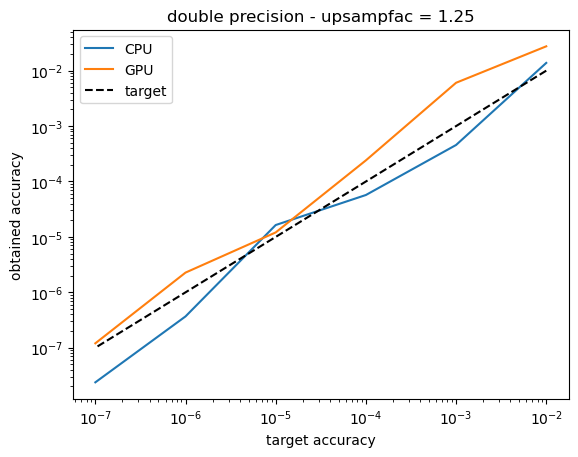

In [11]:
errdata = np.array(errdata)
print(errdata.shape)
plt.plot(epsilons, errdata[:,1], label='CPU')
plt.plot(epsilons, errdata[:,0], label='GPU')
plt.plot(epsilons, epsilons, color='black', ls='--', label='target')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('double precision - upsampfac = 1.25')
plt.xlabel('target accuracy')
plt.ylabel('obtained accuracy')
# plt.ylim(1e-10,1e-5)

(2, 524288) (524288, 2)


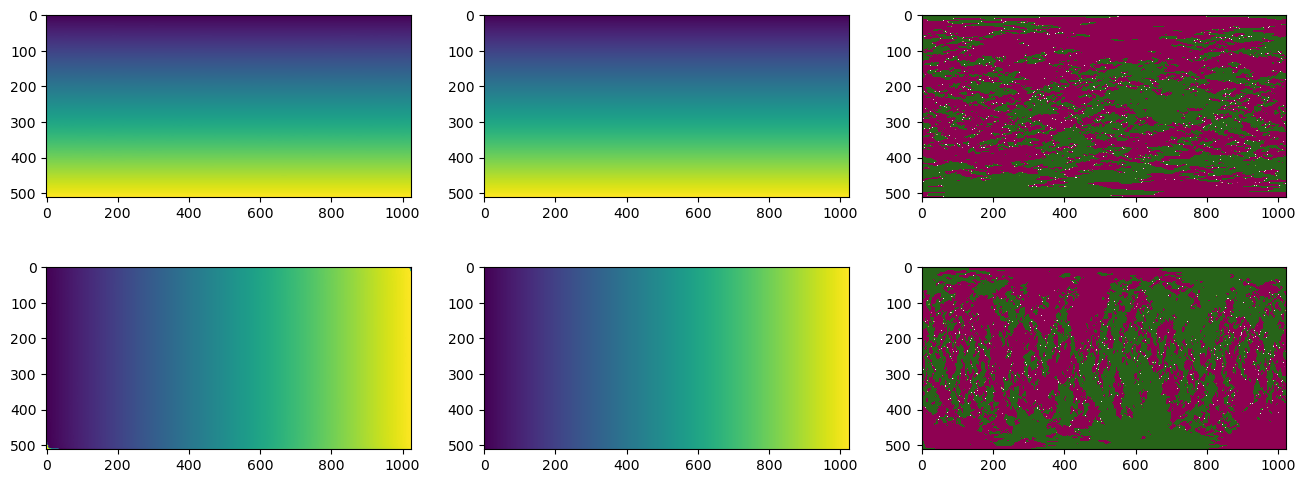

In [14]:
keyGPU = 'dlm2pointing'
keyCPU = 'dlm2pointing'
solverCPU, solverGPU = 'lenspyx', 'cufinufft'

print(defres['GPU'][solverGPU][keyGPU].shape, defres['CPU'][solverCPU][keyCPU].shape)

resCPU = defres['CPU'][solverCPU][keyCPU].T
resGPU = defres['GPU'][solverGPU][keyGPU].T

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(resCPU[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(resGPU[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(resCPU[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(resGPU[:,1].reshape(lmax+1,-1))

ax[0,2].imshow(resCPU[0,:].reshape(lmax+1,-1) - resGPU[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-5, vmax=1e-5)
ax[1,2].imshow(resCPU[1,:].reshape(lmax+1,-1) - resGPU[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-5, vmax=1e-5)

# all others

In [6]:
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
defres['CPU'][solverCPU].keys(), defres['GPU'][solverGPU].keys()

(dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT2d2', 'synthesisgeneral', 'rotate']),
 dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT2d2']))

### pointing things

(2, 524288) (2, 524288)


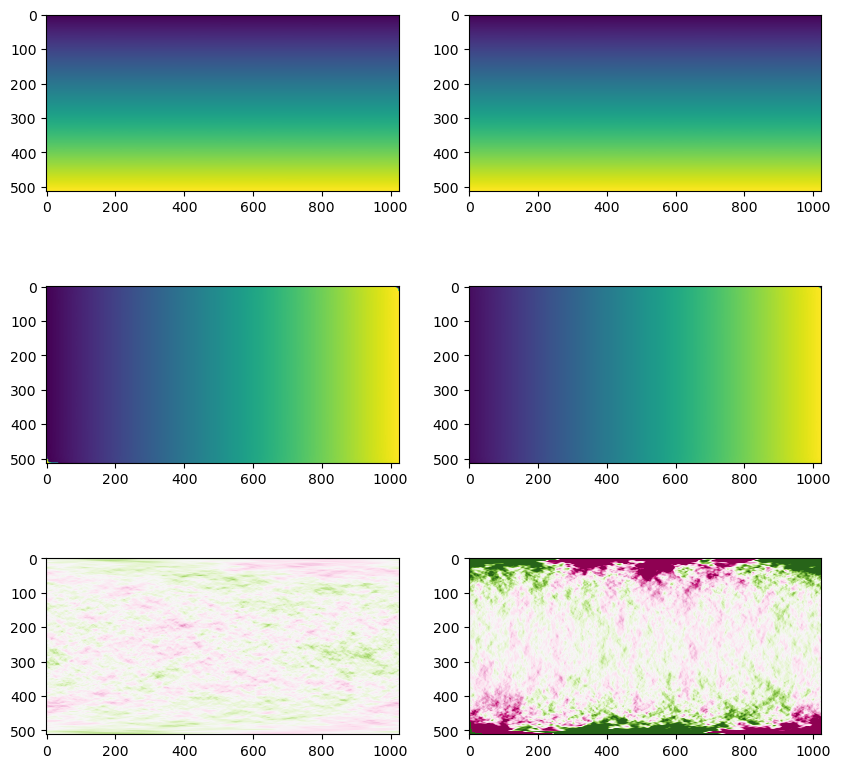

In [7]:
key = 'dlm2pointing'

print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][solverCPU][key][0,:].reshape(phi_lmax+1,-1))
ax[0,1].imshow(defres['GPU'][solverGPU][key].T[:,0].reshape(phi_lmax+1,-1))

ax[1,0].imshow(defres['CPU'][solverCPU][key][1,:].reshape(phi_lmax+1,-1))
ax[1,1].imshow(defres['GPU'][solverGPU][key].T[:,1].reshape(phi_lmax+1,-1))

ax[2,0].imshow((defres['CPU'][solverCPU][key][0,:] - defres['GPU'][solverGPU][key].T[:,0]).reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)
ax[2,1].imshow((defres['CPU'][solverCPU][key][1,:] - defres['GPU'][solverGPU][key].T[:,1]).reshape(phi_lmax+1,-1), cmap='PiYG', vmin=vmin, vmax=vmax)

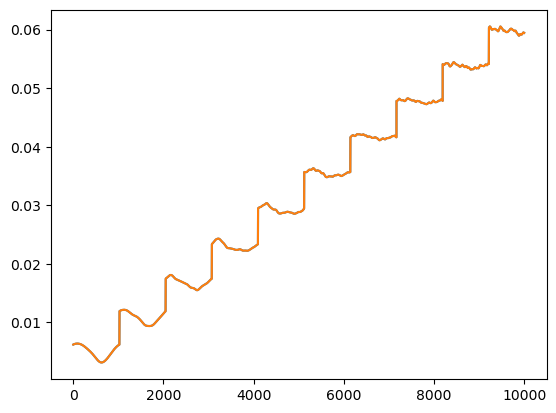

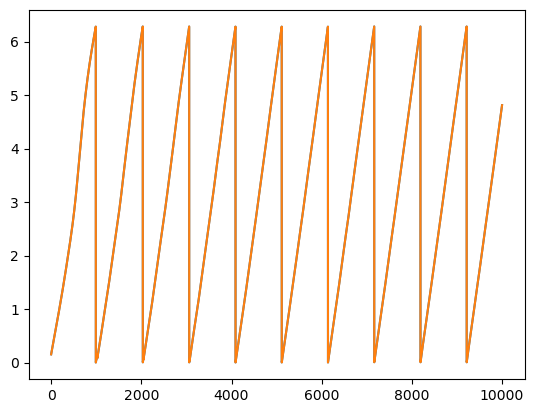

In [8]:
plt.plot(defres['CPU'][solverCPU][key][0,:][0:10000])
plt.plot(defres['GPU'][solverGPU][key].T[:,0][0:10000])
plt.show()

plt.plot(defres['CPU'][solverCPU][key][1,:][0:10000])
plt.plot(defres['GPU'][solverGPU][key].T[:,1][0:10000])

## synthesis general

(528, 1024) (528, 1024)


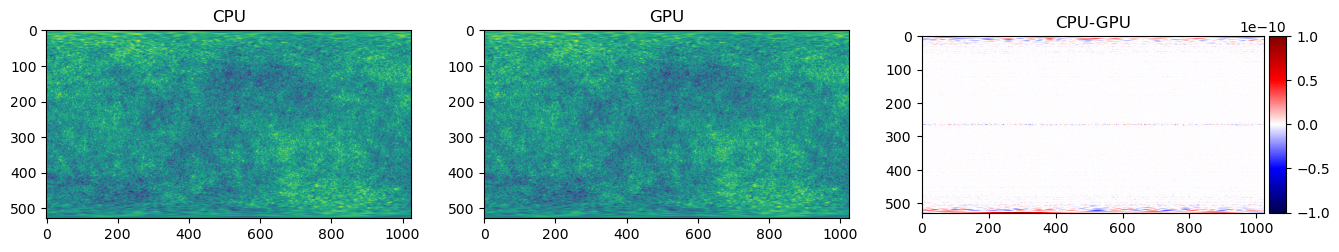

In [9]:
key = 'synthesis'
vmin=-1e-10
vmax=1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))

resCPU = defres['CPU'][solverCPU][key][0]
resGPU = defres['GPU'][solverGPU][key].reshape(t.constructor.nphi,-1).T
print(resCPU.shape, resGPU.shape)

ax[0].imshow(resCPU)
ax[0].set_title('CPU')

ax[1].imshow(resGPU)
ax[1].set_title('GPU')

im = ax[2].imshow(resCPU-resGPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


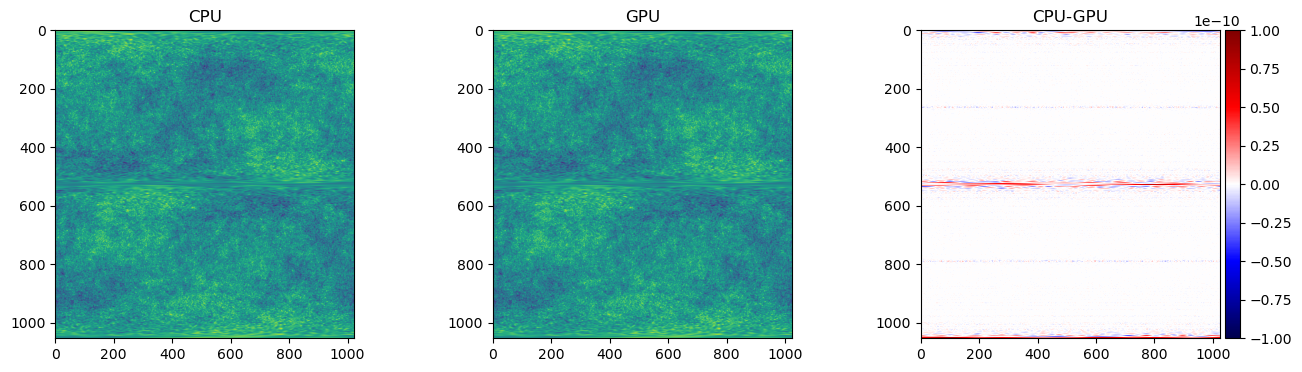

In [10]:
key = 'doubling'
vmin, vmax = -1e-10, 1e-10
fig, ax = plt.subplots(1,3, figsize=(16,4))
resCPU = defres['CPU'][solverCPU][key]
resGPU = defres['GPU'][solverGPU][key].reshape(t.constructor.nphi,-1).T

ax[0].imshow(resCPU)
ax[0].set_title('CPU')

ax[1].imshow(resGPU)
ax[1].set_title('GPU')

im = ax[2].imshow(resCPU-resGPU, cmap='seismic', vmin=vmin, vmax=vmax)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1024, 1054) (1054, 1024)


/tmp/ipykernel_1792442/1600147889.py:43: RuntimeWarning: divide by zero encountered in divide
  im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
/tmp/ipykernel_1792442/1600147889.py:43: RuntimeWarning: invalid value encountered in divide
  im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
/tmp/ipykernel_1792442/1600147889.py:48: RuntimeWarning: divide by zero encountered in divide
  im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
/tmp/ipykernel_1792442/1600147889.py:48: RuntimeWarning: invalid value encountered in divide
  im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
/tmp/ipykernel_1792442/1600147889.py:53: RuntimeWarning: divide by zero encountered in divide
  im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
/tmp/ipykernel_1792442/1600147889.py:53: RuntimeWarning: i

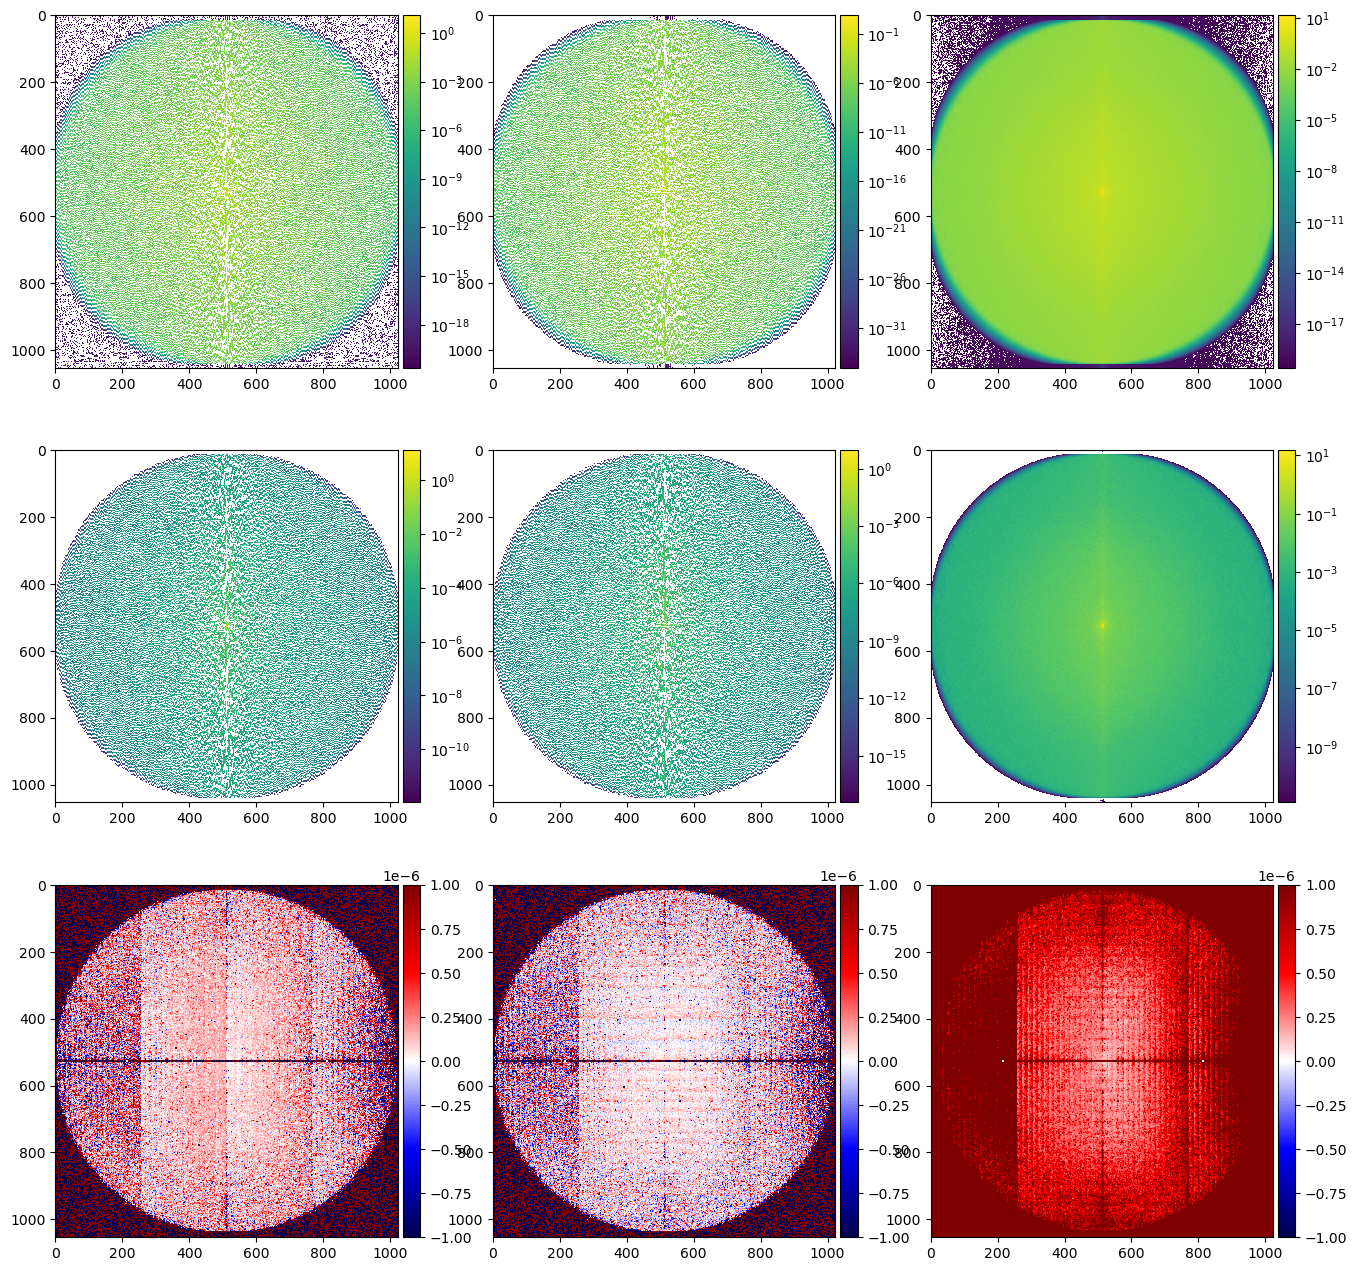

In [16]:
key = 'C2C'
solverCPU, solverGPU = 'duccnufft', 'cufinufft'
# print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)
print(defres['GPU'][solverGPU][key].shape, defres['CPU'][solverCPU][key].shape)

fig, ax = plt.subplots(3,3, figsize=(16,16))

resCPU = np.fft.fftshift(defres['CPU'][solverCPU][key],axes=(0,1)) # [1000:1200,1000:1200]
resGPU = np.fft.fftshift(defres['GPU'][solverGPU][key].reshape(2*(lmax+1),-1).T,axes=(0,1)) # [1000:1200,1000:1200]

im = ax[0,0].imshow(np.real(resCPU), norm='log')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,1].imshow(np.imag(resCPU), norm='log')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
im = ax[0,2].imshow(np.abs(resCPU), norm='log')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(np.real(resGPU), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(resGPU), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(np.abs(resGPU), norm='log')
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -np.min([epsilon,1e-6]), np.min([epsilon,1e-6])
# vmin, vmax = None, None
im = ax[2,0].imshow(np.real((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,2].imshow(np.abs((resCPU - resGPU)/resCPU), vmin=vmin, vmax=vmax, cmap='seismic')
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

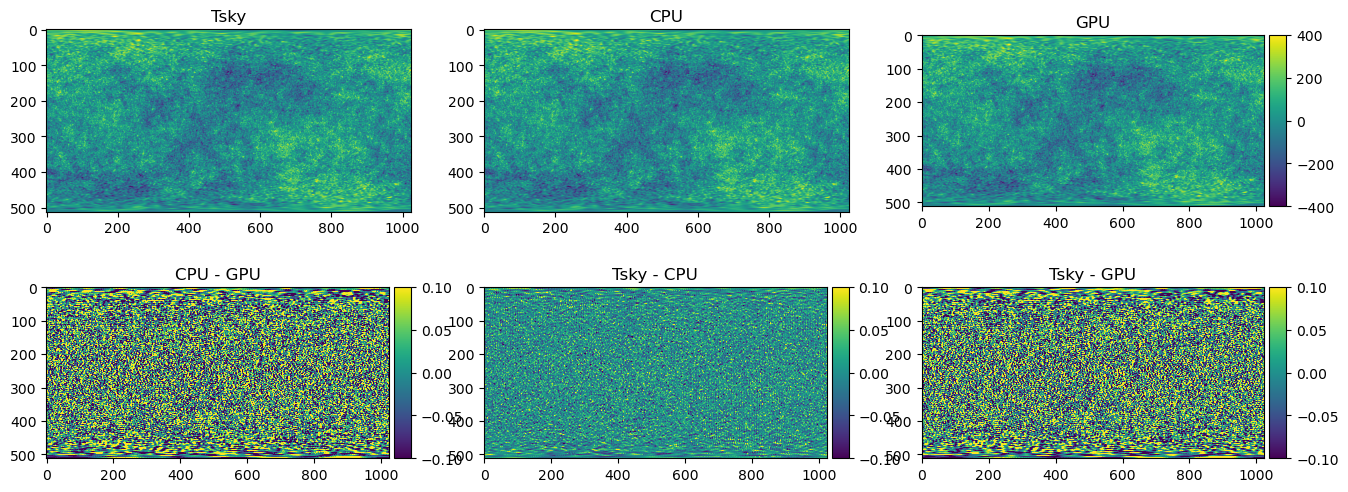

In [17]:
key = 'nuFFT2d2'
Tsky = Tsky2
resCPU = defres['CPU'][solverCPU][key].real
vmin, vmax = -4e2, 4e2
resCPU = defres['CPU'][solverCPU][key].real
resGPU = defres['GPU'][solverGPU][key].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(phi_lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


vmin, vmax = -epsilon*1e1, epsilon*1e1
im = ax[1,0].imshow((resCPU-resGPU).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

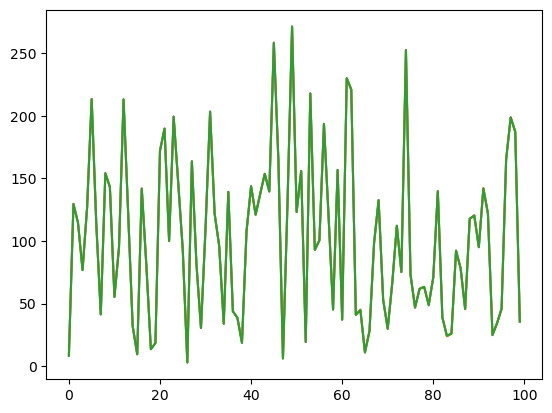

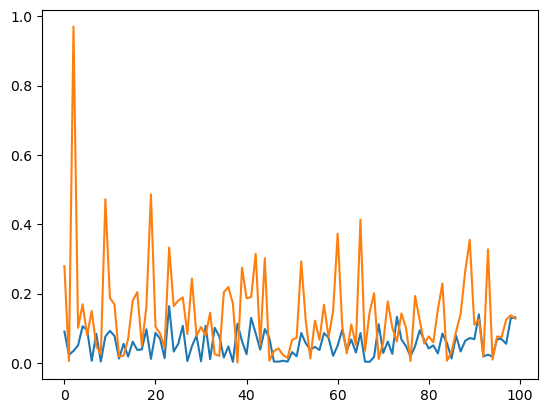

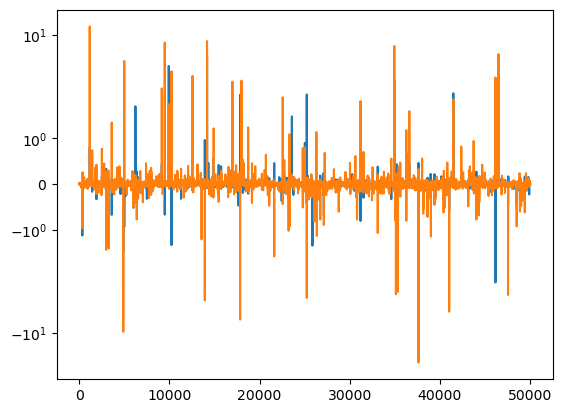

In [18]:
# plt.plot(truth)
plt.plot(np.abs(truth)[100:200])
plt.plot(np.abs(resCPU[pixs])[100:200])
plt.plot(np.abs(resGPU[pixs])[100:200])
# plt.ylim(-epsilon*1e1,epsilon*1e1)
# plt.yscale('log')
plt.show()

plt.plot(np.abs(truth-resCPU[pixs])[0:100])
plt.plot(np.abs(truth-resGPU[pixs])[0:100])
# plt.ylim(-epsilon*1e1,epsilon*1e1)
# plt.yscale('log')
plt.show()

plt.plot((truth-resCPU[pixs])/truth)
plt.plot((truth-resGPU[pixs])/truth)
plt.yscale('symlog')
plt.show()

(3, 2)


Text(0, 0.5, 'obtained accuracy')

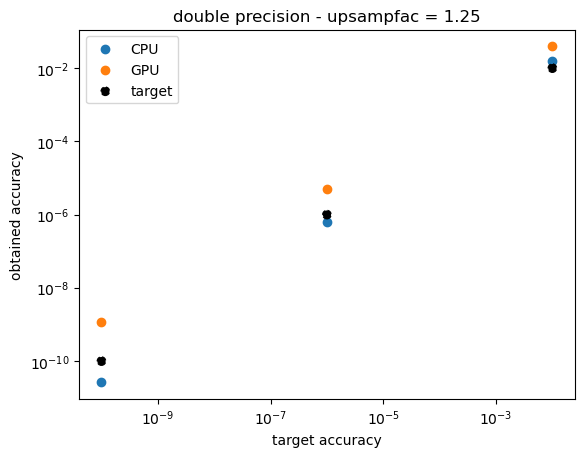

In [2]:
err(truth-resGPU[pixs], truth), err(truth-resCPU.flatten()[pixs], truth)
errdata = np.array(errdata)
print(errdata.shape)
plt.scatter(epsilons, errdata[:,1], label='CPU')
plt.scatter(epsilons, errdata[:,0], label='GPU')
plt.scatter(epsilons, epsilons, color='black', ls='--', label='target')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('double precision - upsampfac = 1.25')
plt.xlabel('target accuracy')
plt.ylabel('obtained accuracy')
# plt.ylim(1e-10,1e-5)